<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UAVSAR-TIFF-CONVERT" data-toc-modified-id="UAVSAR-TIFF-CONVERT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UAVSAR TIFF CONVERT</a></span></li><li><span><a href="#Opening-and-plotting-the-raw-UAVSAR-raster-files" data-toc-modified-id="Opening-and-plotting-the-raw-UAVSAR-raster-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Opening and plotting the raw UAVSAR raster files</a></span><ul class="toc-item"><li><span><a href="#Amp1" data-toc-modified-id="Amp1-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Amp1</a></span></li><li><span><a href="#Amp2" data-toc-modified-id="Amp2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Amp2</a></span></li><li><span><a href="#COR" data-toc-modified-id="COR-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>COR</a></span></li><li><span><a href="#DEM" data-toc-modified-id="DEM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>DEM</a></span></li><li><span><a href="#Unwrapped-Phase" data-toc-modified-id="Unwrapped-Phase-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Unwrapped Phase</a></span></li></ul></li><li><span><a href="#Formatting-the-data-for-visualization" data-toc-modified-id="Formatting-the-data-for-visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Formatting the data for visualization</a></span></li><li><span><a href="#Amplitude-formatting" data-toc-modified-id="Amplitude-formatting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Amplitude formatting</a></span><ul class="toc-item"><li><span><a href="#Coherence,-Unwrapped-Phase,-DEM" data-toc-modified-id="Coherence,-Unwrapped-Phase,-DEM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Coherence, Unwrapped Phase, DEM</a></span></li></ul></li><li><span><a href="#1.7--LiDAR-vs-UNW" data-toc-modified-id="1.7--LiDAR-vs-UNW-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1.7  LiDAR vs UNW</a></span></li></ul></div>

In [1]:
# beforing importing, you'll need to install these packages to the conda environment the notebook is running on

import os
import re
import codecs
#import rasterio
#import numpy
#mport matplotlib
#rom matplotlib import pyplot
#import glob
import subprocess
from osgeo import gdal

#import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

## UAVSAR TIFF CONVERT

In [2]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """


    os.chdir(folder)
    int_file = glob.glob(os.path.join(folder, 'int.grd'))

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    print(Lines)
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    print(Samples)
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    print(Latitude)
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    print(Longitude)
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    # Dan, if you wanted to convert to UTM, it would probably be best in this step
    # but also possibly when making the header, where lat/lon is specified 
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs seperate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)

    print(".tiffs have been created")
    return



In [3]:
#Uncomment to convert the binary files to tiff 

folder = "/home/naheemadebisi/earth-analytics/data/boise/silver_34715_20011-001_20016-002_0019d_s01_L090_01_int_grd/VV" 
uavsar_tiff_convert(folder)



7662

6855

43.374080760000005  
-116.937243120000005
.tiffs have been created


In [4]:
### inspect our newly created .tiffs, and create named objects for each data type. We'll use these new obects in the next step

os.chdir(folder)
# # amplitude from the first acquisition
# for amp1 in glob.glob("*amp1.grd.tiff"):
#     print(amp1)
    
# # amplitude from the second acquisition
# for amp2 in glob.glob("*amp2.grd.tiff"):
#     print(amp2)

# coherence
for cor in glob.glob("*cor.grd.tiff"): #this define our tiff file as obj named 'cor' of type str
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"): #this define our object as unw
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"): #this define our object as dem
    print(dem)

silver_34715_20011-001_20016-002_0019d_s01_L090VV_01.cor.grd.tiff
silver_34715_20011-001_20016-002_0019d_s01_L090VV_01.unw.grd.tiff
silver_34715_20011-001_20016-002_0019d_s01_L090VV_01.hgt.grd.tiff


## Opening and plotting the raw UAVSAR raster files
We now have our five different data sets: the two amplitude files, coherence, unwrapped phased, and the DEM. We will not be working the actual interferogram (.int) file because it contains complex numbers that don't work in the Python packages being used.

Here we will open a raster files using the ```rio.open()``` function. We'll then create a simple plot using the ```rio``` ```show()``` function.

### Amp1
```
Write a code that plot the amplitude1 tiff file 
Values are always between 0 and 1; no need for histogram
```

### Amp2
```
Write a code that plot the amplitude2 tiff file
Values are always between 0 and 1; no need for histogram
```

### COR
```
Write a code that plot the cor tiff file
Values are always between 0 and 1; no need for histogram
```

### DEM
```
Write a code that plot the dem tiff file
we'll make a quick histogram using rio show_hist() to check what we should set the bounds of the color scale to.
```

### Unwrapped Phase
we'll make a quick histogram using rio show_hist() to check what we should set the bounds of the color scale to.

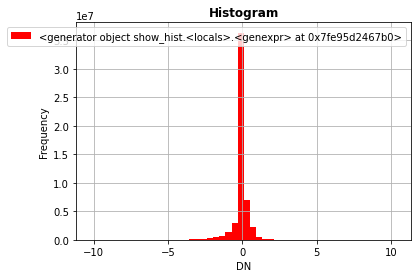

In [5]:
unw_rast = rio.open(unw)
show_hist(unw_rast, bins = 50)

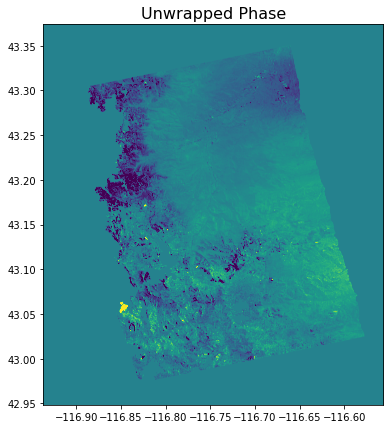

In [6]:
unw_rast = rio.open(unw)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Unwrapped Phase",fontsize = 16);
show((unw_rast, 1), cmap = 'viridis', vmin = -2, vmax = 2.5); # info from histogram

## Formatting the data for visualization
The plots of the raw data need some work. Some fotmatting is necessary to visualize the data clearly. UAVSAR uses "0" as it's no data value (not the best practice in general) for amplitude, coherence, and unwrapped phase. For the DEM -10000 is the no data value. Using -9999 or another value that is obviously not actual data is a better practice with spatial data to limit confusion. We'll convert these no data values to NaN (Not a Number) which will remove the boarders around data, and in data lost the unwrapping in the UNW file.

We'll create a function called show_two_images() to plot two images at once. The function inputs are a data array, color map name, and a plot title for both images. It uses np.nanpercentile() to automatically set the color scale bounds, but you can also set them manually.

In [7]:
# function for showing two images using matplotlib
plt.rcParams.update({'font.size': 12}) # set fontsize
def show_two_images(img1, img2, col1, col2, title1, title2, vmin1=None, vmax1=None, vmin2=None, vmax2=None):

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # auto setting axis limits
    if vmin1 == None:
        vmin1 = np.nanpercentile(img1, 1)
    if vmax1 == None:
        vmax1 = np.nanpercentile(img1, 99)
    
    # plot image
    masked_array1 = np.ma.array(img1, mask=np.isnan(0)) #mask for 0
    plt1 = ax1.imshow(masked_array1, cmap=col1, vmin=vmin1, vmax=vmax1, interpolation = 'nearest') #fixes NaN problem
    ax1.set_title(title1)
    ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin1, vmax1))
        
    # add color scale
    colorbar = fig.colorbar(plt1, ax=ax1, fraction=0.03, pad=0.04)
    
     # auto setting axis limits
    if vmin2 == None:
        vmin2 = np.nanpercentile(img2, 1)
    if vmax2 == None:
        vmax2 = np.nanpercentile(img2, 99)
    
    # plot image
    masked_array2 = np.ma.array(img2, mask=np.isnan(0)) #mask for 0
    plt2 = ax2.imshow(masked_array2, cmap=col2, vmin=vmin2, vmax=vmax2, interpolation = 'nearest')
    ax2.set_title(title2)
    ax2.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin2, vmax2))
    colorbar = fig.colorbar(plt2, ax=ax2, fraction=0.03, pad=0.04)
    plt.show()

## Amplitude formatting
For the two amplitude files we need to do two things. Convert from the linear amplitude scale to decibel (dB) and change the 0 values to NaN. To do this we'll convert our raster file to an ```np.array``` to manipulate it. Note that when we convert the raster data to an array, the spatial coordinates are lost and it no longer plots the x and y scales at longitude and latitude values. For our purposes this okay, but you would need to convert back to a .tiff if you wanted to save the file to use in ArcGIS or QGIS.


In [8]:
# amp1 
# open raster as a data array

#Check code for amp files

### Coherence, Unwrapped Phase, DEM
For these three data types, we only need to convert no data values (0) to NaN.

In [9]:
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1) #read the raster raw pixels as N-D array but no longer spatially referenced(bad)

cor_array[cor_array == 0] = np.nan # convert all 0's to nan

# unw
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)
    
unw_array[unw_array == 0] = np.nan

# dem
with rio.open(dem) as dem_raw:
    dem_array = dem_raw.read(1)
    
dem_array[dem_array == -10000] = np.nan #different no data value

Checking to see if it worked by comparing unw_rast which still includes 0's to unw_array where we changed them to NaN.

In [10]:
#show_hist(unw_rast, bins = 100) 
#show_hist(unw_array, bins = 100)

In [11]:
#plot the unwrapped phase and DEM using show_two_images function
#plt.rcParams.update({'font.size': 12}) # set fontsize
#show_two_images(dem_array, unw_array, 'gist_earth', 'viridis', 'DEM (m)', 'UNW (radians)')

Let's plot the UNW raster larger so we can get a better look at the detail.

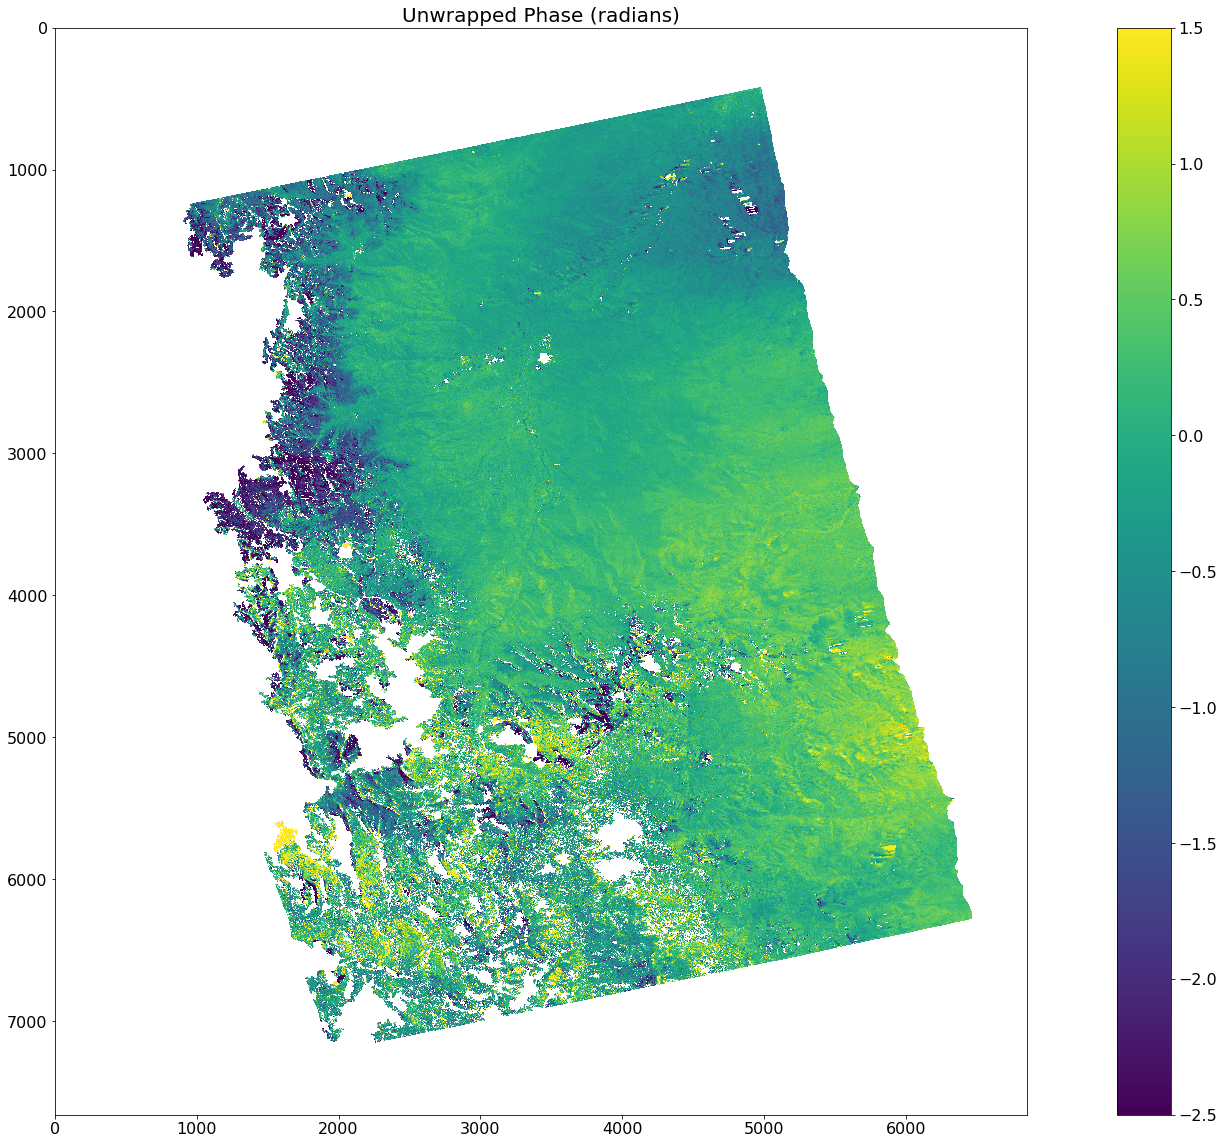

In [27]:
plt.rcParams.update({'font.size': 16}) # increase plot font size for larger plot
fig, ax = plt.subplots(figsize=(40, 20))

masked_array = np.ma.array(unw_array, mask = np.isnan(0)) # mask for 0
ax.set_title("Unwrapped Phase (radians)", fontsize= 20) #title and font size
img = ax.imshow(masked_array, cmap = 'viridis', interpolation = 'nearest', vmin = -2.5, vmax =1.5)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()
plt.rcParams.update({'font.size': 12}) # change font back to normal

This looks much better! Plotting the image at a larger scale allows us to see an accurate representation of the data.

In [13]:
# Show that phase change from SAR and depth change from Lidar is really similar

LiDAR depth change vs InSAR Phase change Comparison
The SnowEx 2020 campaign conducted a pair of LiDAR and InSAR flights over Grand Mesa on February 1st and 13th. The purpose of the paired data collected was to test the UAVSAR L-band InSAR SWE/Depth change technique against the LiDAR depth change retrievals. LiDAR is proven to work exceptionally well for measuring snow depth changes, so this provides an opportunity to validate the InSAR data.

In [35]:
lidar_dc = '/home/naheemadebisi/earth-analytics/data/boise/ASO_Reynolds_mosaic_2020Feb18-19_AllData_and_Reports/ASO_ReynoldsCreek_2020Feb18-19_snowdepth_3m.tif' #path to lidar depth change raster

# print meta data, and check to see if the raster has a no data value
lidar_rast = rio.open(lidar_dc)
meta_data = lidar_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4661, 'height': 9351, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(3.0, 0.0, 511374.0,
       0.0, -3.0, 4795620.0), 'tiled': False, 'interleave': 'band'}


We can see this raster has a no data value of 'nodata': -3.4e+38 set (most of the UAVSAR ones did not). Therefore we can read it in with the masked=TRUE command to automatically mask out the no data pixels.

In [36]:
with rio.open(lidar_dc) as dataset:
    lidar_masked = dataset.read(1, masked=False)

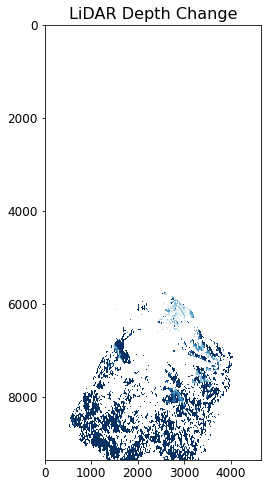

<AxesSubplot:title={'center':'LiDAR Depth Change'}>

In [37]:
# quick test plot
fig, ax = plt.subplots(figsize = (30,8))
ax.set_title("LiDAR Depth Change",fontsize = 16);
show((lidar_masked), cmap = 'RdBu', vmin = -.3, vmax = .3)

## 1.7  LiDAR vs UNW

Using show_two_images(), we can plot the LiDAR depth change and UNW images next to each other to compare them.

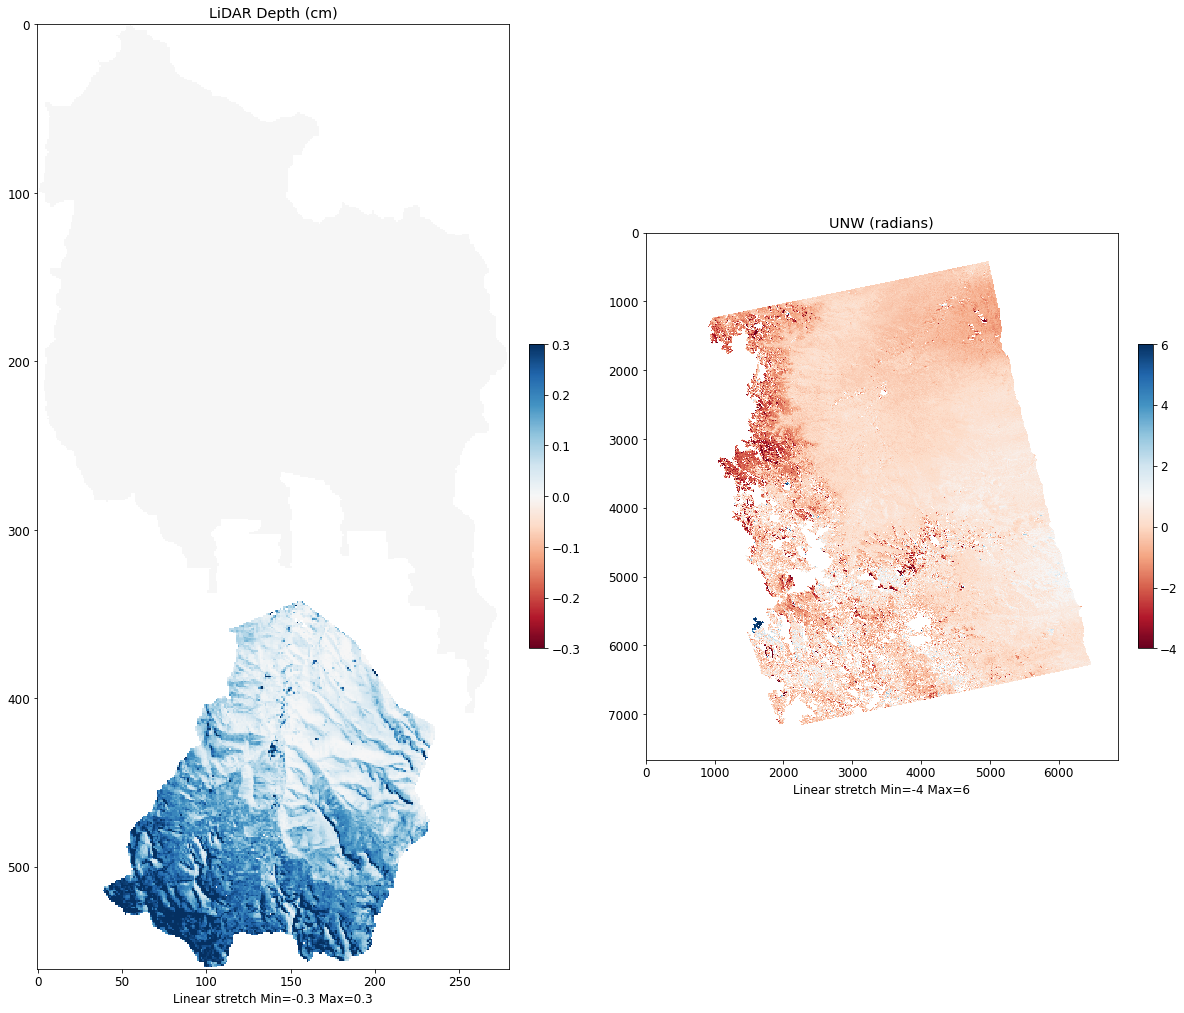

In [31]:
show_two_images(lidar_masked, unw_array, 'RdBu', 'RdBu', 'LiDAR Depth (cm)', 'UNW (radians)', vmin1 = -.3, vmax1 = .3, vmin2=-4, vmax2=6)